# Testing
### Geschossflächen nach Nutzungsarten, Stadtquartier und Bauperiode seit 1970
Datum: 03.02.2022

### Importiere die notwendigen Packages

In [1]:
#%pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly

In [2]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
#from datetime import datetime
import datetime
import geopandas as gpd
import folium 
import plotly.express as px
import seaborn as sns


Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [3]:
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Zeitvariabeln
Bestimme den aktuellst geladenen Monat. Hier ist es der Stand vor 2 Monaten. 
Bestimme noch weitere evt. sinnvolle Zeitvariabeln.

Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime

Zuerst die Zeitvariabeln als Strings

In [4]:
#today_date = datetime.date.today()
#date_time = datetime.datetime.strptime(date_time_string, '%Y-%m-%d %H:%M')
now = datetime.date.today()
date_today = now.strftime("%Y-%m-%d")
year_today = now.strftime("%Y")
month_today = now.strftime("%m")
day_today = now.strftime("%d")


Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [5]:
#now = datetime.now() 
int_times = now.timetuple()

aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2

print(aktuellesJahr, 
      aktuellerMonat,
    'datenstand: ', selectedMonat,
     int_times)


2022 2 datenstand:  0 time.struct_time(tm_year=2022, tm_mon=2, tm_mday=8, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=1, tm_yday=39, tm_isdst=-1)


Berechne die Variable Epoche um später das SAS-Datum in ein Unix-Datum umzuwandeln. Bei SAS beginnt die Epoche am 1.1.1960. Bei Unix am 1.1.1970.
Diese Variable wird beim CSV-Import benötigt.

In [6]:
epoch = datetime.datetime(1960, 1, 1)

### Importiere einen Datensatz 

- Beachte dabei die Notation des Pfades...
- Definiere mal aktuell noch keine weiteren Parameter beim Import

**Dataset auf INTEG Datenkatalog**:  https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bau_geschossflaeche_nutzungsart_quartier_bp_seit1970_od5231

**Dataset auf PROD Datenkatalog**:  https://data.stadt-zuerich.ch/dataset/bau_geschossflaeche_nutzungsart_quartier_bp_seit1970_od5231


In [70]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "prod";
print(status)

prod


In [71]:
# Filepath
if status == "prod":
    fp = r"https://data.stadt-zuerich.ch/dataset/bau_geschossflaeche_nutzungsart_quartier_bp_seit1970_od5231/download/BAU523OD5231.csv"
else:
    fp = r"\\szh\ssz\applikationen\OGD_Dropzone\INT_DWH\bau_geschossflaeche_nutzungsart_quartier_bp_seit1970_od5231\BAU523OD5231.csv"   

print(fp)

https://data.stadt-zuerich.ch/dataset/bau_geschossflaeche_nutzungsart_quartier_bp_seit1970_od5231/download/BAU523OD5231.csv


In [84]:
# Read the data
data2betested = pd.read_csv(
    fp
    , sep=','
    ,parse_dates=['StichtagDatJahr']
    # KONVERTIERE DAS SAS DATUM IN EIN UNIXDATUM UND FORMATIERE ES
    #, date_parser=lambda s: epoch + datetime.timedelta(days=int(s))
    ,low_memory=False    
    )

print('done')

done


In der Folge ein paar erste Tests:

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [85]:
#data2betested.head(6)

In den Bau-Datensätzen kommen manchmal die Attribute `Jahr` oder `StichDatJahr` vor. Diese werden hier für solche Fälle 'harmonisiert'.

In [86]:
if set(['StichtagDatJahr']).issubset(data2betested.columns):
    data2betested['Jahr'] = data2betested['StichtagDatJahr'] 

In [87]:
data2betested.dtypes

StichtagDatJahr    datetime64[ns]
QuarSort                    int64
QuarLang                   object
KreisSort                   int64
KreisLang                  object
Bauperiode                 object
NuFlTotal                   int64
NuFlHaupt                   int64
NuFlWohnen                  int64
NuFlBuero                   int64
NuFlVerk                    int64
NuFlProd                    int64
NuFlAndere                  int64
NuFlLager                   int64
NuFlPark                    int64
Jahr               datetime64[ns]
dtype: object

In [88]:
data2betested.shape

(4039, 16)

Beschreibe einzelne Attribute

In [89]:
data2betested.describe()

,QuarSort,KreisSort,NuFlTotal,NuFlHaupt,NuFlWohnen,NuFlBuero,NuFlVerk,NuFlProd,NuFlAndere,NuFlLager,NuFlPark
count,4039,4039,4039,4039,4039,4039,4039,4039,4039,4039,4039
mean,65,6,258648,178623,101437,37962,11279,9849,18098,61956,18069
std,36,4,326036,226382,145738,59230,22560,25746,23353,86232,24661
min,11,1,11,0,0,0,0,0,0,0,0
25%,33,3,61198,40604,16680,2808,921,370,2697,11618,3774
50%,71,7,139568,92682,44923,14012,3590,2087,11173,32445,9796
75%,92,9,343932,228134,117716,47210,11956,9504,23947,77394,24392
max,123,12,4005527,2603805,1259385,669527,279398,492668,324014,1059669,342053


Wie viele Nullwerte gibt es im Datensatz?

In [90]:
data2betested.isnull().sum()

StichtagDatJahr      0
QuarSort             0
QuarLang             0
KreisSort            0
KreisLang            0
Bauperiode         170
NuFlTotal            0
NuFlHaupt            0
NuFlWohnen           0
NuFlBuero            0
NuFlVerk             0
NuFlProd             0
NuFlAndere           0
NuFlLager            0
NuFlPark             0
Jahr                 0
dtype: int64

### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [91]:
data2betested = data2betested.set_index("StichtagDatJahr")

In [92]:
data2betested.info()
data2betested.index.day.unique()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4039 entries, 1970-01-01 to 2021-01-01
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   QuarSort    4039 non-null   int64         
 1   QuarLang    4039 non-null   object        
 2   KreisSort   4039 non-null   int64         
 3   KreisLang   4039 non-null   object        
 4   Bauperiode  3869 non-null   object        
 5   NuFlTotal   4039 non-null   int64         
 6   NuFlHaupt   4039 non-null   int64         
 7   NuFlWohnen  4039 non-null   int64         
 8   NuFlBuero   4039 non-null   int64         
 9   NuFlVerk    4039 non-null   int64         
 10  NuFlProd    4039 non-null   int64         
 11  NuFlAndere  4039 non-null   int64         
 12  NuFlLager   4039 non-null   int64         
 13  NuFlPark    4039 non-null   int64         
 14  Jahr        4039 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(11), object(3)
memory usag

Int64Index([1], dtype='int64', name='StichtagDatJahr')

### Einfache Visualisierungen zur Plausi

Exploriere die Daten mit Pivottable.JS

In [93]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [94]:
data2betested.loc["1985"].head(2)
#data2betested.loc["2021-10-31":"2021-11-30"].head(2)

,QuarSort,QuarLang,KreisSort,KreisLang,Bauperiode,NuFlTotal,NuFlHaupt,NuFlWohnen,NuFlBuero,NuFlVerk,NuFlProd,NuFlAndere,NuFlLager,NuFlPark,Jahr
StichtagDatJahr,,,,,,,,,,,,,,,
1985-01-01,11,Rathaus,1,Kreis 1,NaN,686500,521700,205300,129537,123800,29000,34063,162000,2800,1985-01-01
1985-01-01,12,Hochschulen,1,Kreis 1,NaN,653700,472400,50200,259685,64800,20000,77715,143000,38300,1985-01-01


### Visualisierungen nach Zeitausschnitten

#### Entwicklung des Geschossflächen nach Bauperiode seit 1970

In [100]:
#data2betested.columns

In [108]:
myAgg = data2betested.loc["1970":"2021"].reset_index()\
    .groupby(['StichtagDatJahr', 'Bauperiode']) \
    .agg(sum_NuFlTotal=('NuFlTotal', 'sum'), sum_NuFlHaupt=('NuFlHaupt', 'sum'), sum_NuFlWohnen=('NuFlWohnen', 'sum')
        , sum_NuFlBuero=('NuFlBuero', 'sum'), sum_NuFlVerk=('NuFlVerk', 'sum'), sum_NuFlProd=('NuFlProd', 'sum')
         , NuFlAndere=('NuFlAndere', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

#myAgg.reset_index()


In [107]:
highlight = alt.selection(type='single', on='mouseover',
                          fields=['Bauperiode'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index().query('sum_NuFlTotal > 1'), title="Title").encode(
    x=alt.X('StichtagDatJahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_NuFlVerk', axis=alt.Axis(title='Anz. Gebäude'))
    , color=alt.Color('Bauperiode', legend=alt.Legend(title="Bauperiode", orient="right"))  
    ,tooltip=['StichtagDatJahr', 'Bauperiode','sum_NuFlTotal','sum_NuFlWohnen','sum_NuFlBuero','sum_NuFlVerk']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Barcharts mit Seaborn

In [ ]:
#data2betested.dtypes

In [110]:
myAggBar = data2betested.loc["1970":"2021"].reset_index()\
    .groupby(['StichtagDatJahr', 'Bauperiode']) \
    .agg(sum_NuFlTotal=('NuFlTotal', 'sum'), sum_NuFlHaupt=('NuFlHaupt', 'sum'), sum_NuFlWohnen=('NuFlWohnen', 'sum')
        , sum_NuFlBuero=('NuFlBuero', 'sum'), sum_NuFlVerk=('NuFlVerk', 'sum'), sum_NuFlProd=('NuFlProd', 'sum')
         , NuFlAndere=('NuFlAndere', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

#myAgg.reset_index()


In [111]:
#help(sns.catplot)     

In [112]:
#Stile for the following sns graphs
sns.set_theme(style="whitegrid")

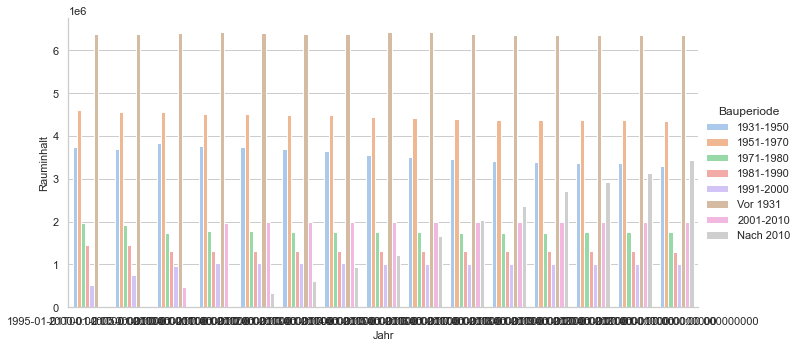

In [114]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="StichtagDatJahr"
            , y="sum_NuFlWohnen"
            , hue="Bauperiode"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="pastel" #, color="green"
            , height=5
            , aspect=2
            , order=None, legend_out=True
            ,data=myAggBar.reset_index()
           )
myHist.set_xlabels('Jahr', fontsize=11) # not set_label
myHist.set_ylabels('Rauminhalt', fontsize=11)


In [115]:
data2betested.dtypes

QuarSort               int64
QuarLang              object
KreisSort              int64
KreisLang             object
Bauperiode            object
NuFlTotal              int64
NuFlHaupt              int64
NuFlWohnen             int64
NuFlBuero              int64
NuFlVerk               int64
NuFlProd               int64
NuFlAndere             int64
NuFlLager              int64
NuFlPark               int64
Jahr          datetime64[ns]
dtype: object

##### Entwicklung der Anzahl projektierter Wohnungen pro Kreis nach Eigentumsart

In [118]:
myAggBar = data2betested.loc["1970":"2021"].reset_index()\
    .groupby(['StichtagDatJahr', 'Bauperiode','KreisSort','KreisLang']) \
    .agg(sum_NuFlTotal=('NuFlTotal', 'sum'), sum_NuFlHaupt=('NuFlHaupt', 'sum'), sum_NuFlWohnen=('NuFlWohnen', 'sum')
        , sum_NuFlBuero=('NuFlBuero', 'sum'), sum_NuFlVerk=('NuFlVerk', 'sum'), sum_NuFlProd=('NuFlProd', 'sum')
         , NuFlAndere=('NuFlAndere', 'sum')) \
    .sort_values('KreisSort', ascending=True) 

#myAgg.reset_index()

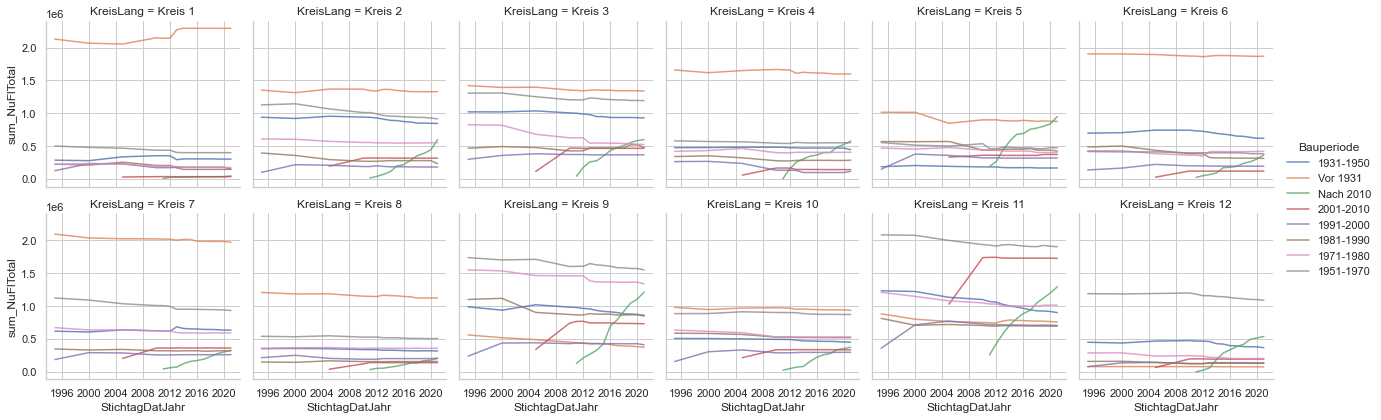

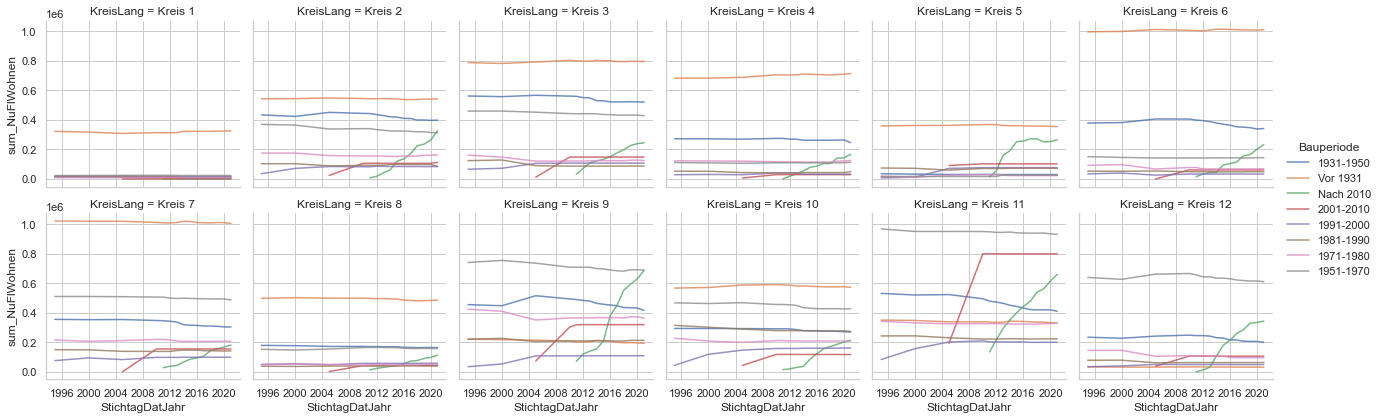

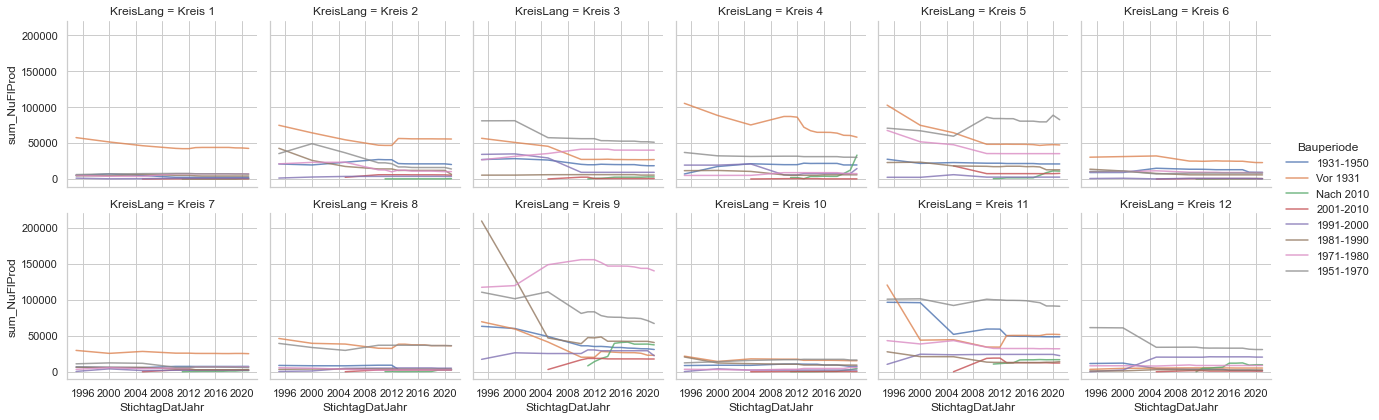

In [119]:
#['StichtagDatJahr', 'Bauperiode','sum_NuFlTotal','sum_NuFlWohnen','sum_NuFlBuero','sum_NuFlVerk']  

g = sns.FacetGrid(myAggBar.reset_index(), col="KreisLang", hue="Bauperiode", col_wrap=6, height=3,)
#g.map(sns.scatterplot, "Jahr", "sum_AnzWhg", alpha=.8)
g.map(sns.lineplot, "StichtagDatJahr","sum_NuFlTotal", alpha=.8)
g.add_legend()

g2 = sns.FacetGrid(myAggBar.reset_index(), col="KreisLang", hue="Bauperiode", col_wrap=6, height=3,)
g2.map(sns.lineplot, "StichtagDatJahr","sum_NuFlWohnen", alpha=.8)
g2.add_legend()

g3 = sns.FacetGrid(myAggBar.reset_index(), col="KreisLang", hue="Bauperiode", col_wrap=6, height=3,)
g3.map(sns.lineplot, "StichtagDatJahr","sum_NuFlProd", alpha=.8)
g3.add_legend()


### Daten in interaktiver Treemap zeigen
Dazu gibt es eine sehr nützliche Webseite https://plotly.com/python/treemaps/
Zu Farbskalen, siehe: https://plotly.com/python/builtin-colorscales/

#### Bürogeschossflächen nach Bauperioden und Quartier 2021

In [123]:
#data2betested.dtypes

In [124]:
myTreemapAgg = data2betested.loc["2021"]\
    .groupby(['StichtagDatJahr', 'Bauperiode','KreisSort','KreisLang','QuarLang']) \
    .agg(sum_NuFlTotal=('NuFlTotal', 'sum'), sum_NuFlHaupt=('NuFlHaupt', 'sum'), sum_NuFlWohnen=('NuFlWohnen', 'sum')
        , sum_NuFlBuero=('NuFlBuero', 'sum'), sum_NuFlVerk=('NuFlVerk', 'sum'), sum_NuFlProd=('NuFlProd', 'sum')
         , NuFlAndere=('NuFlAndere', 'sum')) \
    .sort_values('KreisSort', ascending=True) 

myTreemapAgg.reset_index().dtypes

StichtagDatJahr    datetime64[ns]
Bauperiode                 object
KreisSort                   int64
KreisLang                  object
QuarLang                   object
sum_NuFlTotal               int64
sum_NuFlHaupt               int64
sum_NuFlWohnen              int64
sum_NuFlBuero               int64
sum_NuFlVerk                int64
sum_NuFlProd                int64
NuFlAndere                  int64
dtype: object

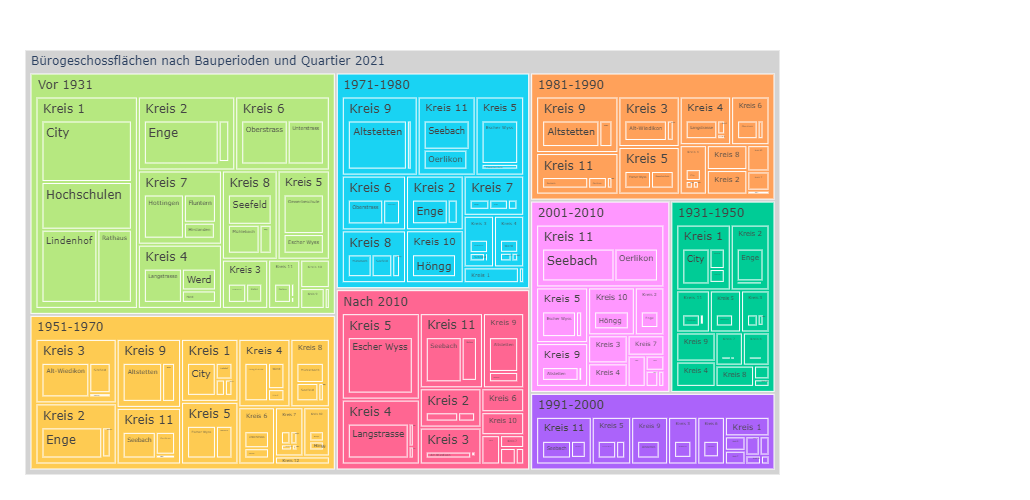

In [129]:
fig = px.treemap(myTreemapAgg.query('sum_NuFlBuero >0').reset_index(), path=[px.Constant("Bürogeschossflächen nach Bauperioden und Quartier 2021")
                                                                                      ,'Bauperiode','KreisLang','QuarLang']
                 , values='sum_NuFlBuero'
                 , color='Bauperiode'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 , color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='cividis'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])  
                 ,height=500
                 ,width=1300                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

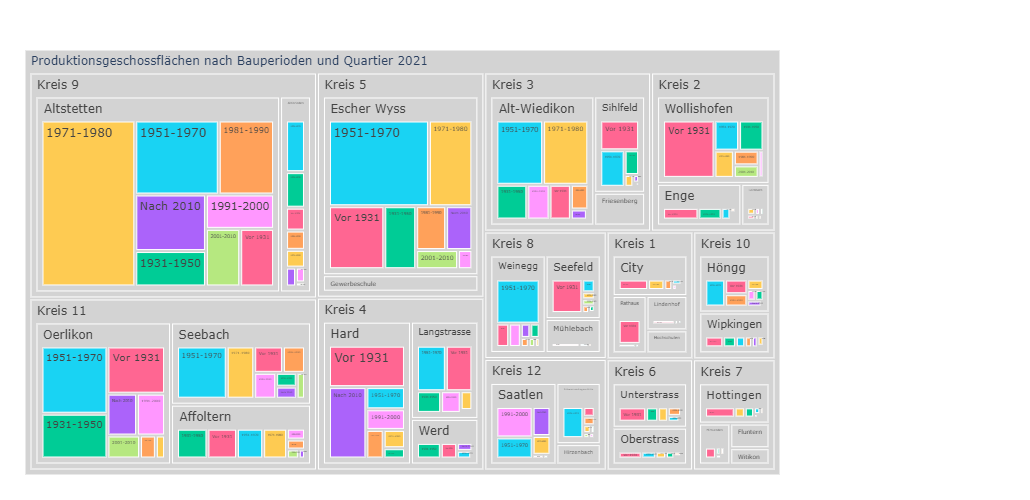

In [132]:
fig = px.treemap(myTreemapAgg.query('sum_NuFlProd >0').reset_index(), path=[px.Constant("Produktionsgeschossflächen nach Bauperioden und Quartier 2021")
                                                                                      ,'KreisLang','QuarLang','Bauperiode']
                 , values='sum_NuFlProd'
                 , color='Bauperiode'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 , color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='cividis'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])  
                 ,height=500
                 ,width=1300                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

In [212]:
#data2betested.dtypes

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/DispForm.aspx?ID=451&ContentTypeId=0x0100988EAF029F1EFE4CA675F53C32A5D53D01006DBC563E6FBE9E4EB6FDC780799752E1)**

## ---------------------- hier Plausi beendet

Liniendiagramm 
[Link zur Doku](https://altair-viz.github.io/gallery/multiline_highlight.html)

### Test: Choroplethenkarte
Importiere die Geodaten als GeoJSON

#### Stadtkreise

In [124]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
geojson_url_kreise = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Stadtkreise?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_stadtkreise_v"
adm_stadtkreise_v = gpd.read_file(geojson_url_kreise)

adm_stadtkreise_v.head(1)


,id,kname,knr,objid,geometry
0,adm_stadtkreise_v.6,Kreis 7,7,6,"POLYGON ((8.54885 47.36602, 8.54901 47.36601, ..."


#### Statistische Zonen

In [115]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
geojson_url_statzonen = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Zonen?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statzonen_map"
adm_statzonen_map = gpd.read_file(geojson_url_statzonen)

adm_statzonen_map.head(2)


,id,kname,knr,objectid,objid,qname,qnr,stzname,stznr,geometry
0,adm_statzonen_map.1,Kreis 7,7,1,154,Hirslanden,73,Hegibach,7303,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ..."
1,adm_statzonen_map.2,Kreis 7,7,2,89,Hirslanden,73,Klus,7302,"POLYGON ((8.57281 47.35806, 8.57278 47.35807, ..."


#### Statistische Quartiere

In [119]:
geojson_url_quartiere = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Quartiere?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statistische_quartiere_map"
df_adm_statistische_quartiere_map = gpd.read_file(geojson_url_quartiere)

df_adm_statistische_quartiere_map.head(2)


,id,kname,knr,objectid,objid,qname,qnr,geometry
0,adm_statistische_quartiere_map.1,Kreis 7,7,1,34,Hirslanden,73,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ..."
1,adm_statistische_quartiere_map.2,Kreis 8,8,2,33,Weinegg,83,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ..."


### Joins
Joine die importierten statistischen Daten des aktuellen Jahres zum Geodatensatz:

*Siehe dazu Doku zu [Geopandas](https://geopandas.org/docs/user_guide/mergingdata.html)*

In [127]:
data2betested.dtypes

StatZoneCd             int64
StatZone              object
QuarCd                 int64
QuarLang              object
KreisCd                int64
KreisLang             object
EigentumsartSort       int64
Eigentumsart          object
Whg_abgebrochen        int64
Whg_fertigerstellt     int64
dtype: object

In [137]:
myAgg = data2betested.loc["2021"]  \
    .groupby(['QuarLang', 'QuarCd']) \
    .agg(sum_Whg_abgebrochen=('Whg_abgebrochen', 'sum'),sum_Whg_fertigerstellt=('Whg_fertigerstellt', 'sum')) \
    .sort_values('sum_Whg_abgebrochen', ascending=False) 

myAgg.reset_index().head(1)


,QuarLang,QuarCd,sum_Whg_abgebrochen,sum_Whg_fertigerstellt
0,Albisrieden,91,282,89


In [138]:
# Rename attribute stznr to StatZoneSort, so the IDs have the same name
gdf_adm_statistische_quartiere_map = df_adm_statistische_quartiere_map[['geometry', 'qnr', 'qname', 'knr']].rename(columns={'qnr': 'QuarCd'})
gdf_adm_statistische_quartiere_map.head(1)

,geometry,QuarCd,qname,knr
0,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ...",73,Hirslanden,7


In [139]:
# Merge with `merge` method on shared variable (stznr und StatZoneSort):
gdf_adm_statistische_quartiere_map_joined = gdf_adm_statistische_quartiere_map.merge(myAgg, on='QuarCd')
gdf_adm_statistische_quartiere_map_joined.head(2)


,geometry,QuarCd,qname,knr,sum_Whg_abgebrochen,sum_Whg_fertigerstellt
0,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ...",73,Hirslanden,7,48,2
1,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ...",83,Weinegg,8,2,0


<AxesSubplot:>

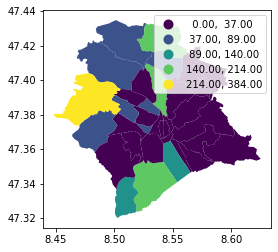

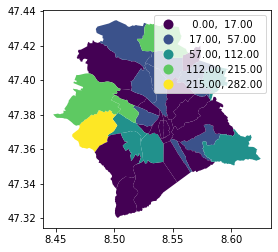

In [142]:
# Plot by StatQuartiere
# Weitere Schemes: scheme='quantiles', scheme='fisherjenks', scheme='natural_breaks',

gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_fertigerstellt', cmap='viridis', scheme='natural_breaks', legend=True )
gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='viridis', scheme='natural_breaks', legend=True )

#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='plasma', scheme='fisherjenks', legend=True )
#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_fertigerstellt', cmap='cool', scheme='quantiles', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

#
#Neuere Gallerie: https://matplotlib.org/stable/gallery/index.html

<AxesSubplot:>

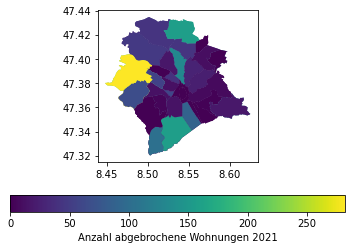

In [157]:
fig, ax = plt.subplots(1, 1)

gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', ax=ax, legend=True, legend_kwds={'label': "Anzahl abgebrochene Wohnungen 2021",'orientation': "horizontal"})
gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_fertigerstellt', ax=ax, legend=False, legend_kwds={'label': "Anzahl fertigerstellte Wohnungen 2021",'orientation': "horizontal"})

#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='viridis', scheme='natural_breaks', legend=True , ax=ax, legend_kwds={'label': "Anzahl Personen",'orientation': "horizontal"})

Noch zu prüfen, folgendes schöne Beispiel: https://docs.bokeh.org/en/latest/docs/user_guide/interaction/legends.html

Konkrete Beispiele von Bookeh in Jupyter NB: https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/DispForm.aspx?ID=451&ContentTypeId=0x0100988EAF029F1EFE4CA675F53C32A5D53D01006DBC563E6FBE9E4EB6FDC780799752E1)**